In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import keras
from PIL import Image, ImageFilter
%matplotlib inline

In [ ]:
from google.colab import drive
drive._mount('/content/drive')


Mounted at /content/drive


## Lecture des jeux de données

In [ ]:
img = glob.glob('/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/*/*.png') # tf.io.glob.glob
label = glob.glob('/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/*/*_gtFine_labelIds.png')
img_names = [path.split('/train/')[1].split('_leftImg8bit.png')[0] for path in img]
label = ['/content/drive/MyDrive/P8/data/gtFine/gtFine/train/' + name + '_gtFine_labelIds.png' for name in img_names]

len(img)

2975

On pré-mélange les données afin de réduire la taille sur la mémoire tampon

In [ ]:
index = np.random.permutation(2975)
img = np.array(img)[index]
label = np.array(label)[index]

img[:5], label[:5]

(array(['/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/jena/jena_000043_000019_leftImg8bit.png',
        '/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/strasbourg/strasbourg_000000_008603_leftImg8bit.png',
        '/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/dusseldorf/dusseldorf_000114_000019_leftImg8bit.png',
        '/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/strasbourg/strasbourg_000001_045880_leftImg8bit.png',
        '/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/train/dusseldorf/dusseldorf_000106_000019_leftImg8bit.png'],
       dtype='<U122'),
 array(['/content/drive/MyDrive/P8/data/gtFine/gtFine/train/jena/jena_000043_000019_gtFine_labelIds.png',
        '/content/drive/MyDrive/P8/data/gtFine/gtFine/train/strasbourg/strasbourg_000000_008603_gtFine_labelIds.png',
        '/content/drive/MyDrive/P8/data/gtFine/gtFine/train/dusseldorf/dusseldorf_000114_000019_gtFine_labelIds.png',
        '/content/drive/My

In [ ]:
val_img = glob.glob('/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/val/*/*.png') # tf.io.glob.glob
val_label = glob.glob('/content/drive/MyDrive/P8/data/leftImg8bit/leftImg8bit/val/*/*_gtFine_labelIds.png')
img_names = [path.split('/val/')[1].split('_leftImg8bit.png')[0] for path in val_img]
val_label = ['/content/drive/MyDrive/P8/data/gtFine/gtFine/val/' + name + '_gtFine_labelIds.png' for name in img_names]

len(val_img), len(val_label)

(500, 500)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((img, label))
val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_label))

In [ ]:
def read_png(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=3)
    return img
    
def read_png_label(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    return img

## Augmentation de données 

1. rotation aléatoire
2. changement d’échelle aléatoire
3. Ajout de bruit



In [ ]:
def rand_crop(img, label):
    concat_img = tf.concat([img, label], axis=-1)
    concat_img = tf.image.resize(concat_img, [280, 560], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[:, :, :3], crop_img[:, :, 3:]

def norm(img, label):
    img = tf.cast(img, tf.float32)/127.5-1
    label = tf.cast(label, tf.int32)
    return img, label

def blur(img, label):
    img = tf.cast(img, Image.open(source).filter(ImageFilter.BLUR))
    return img, label

In [ ]:
def load_img_train(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img, label = rand_crop(img, label)
    
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)
    return norm(img, label)

def load_img_val(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img = tf.image.resize(img, [256, 256])
    label = tf.image.resize(label, [256, 256])
    return norm(img, label)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 300
steps_per_epoch = 2975 // BATCH_SIZE
validation_steps = 500 // BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_img_train, num_parallel_calls=auto)
val_ds = val_ds.map(load_img_val, num_parallel_calls=auto)

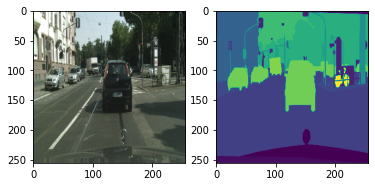

In [ ]:
for img, label in val_ds.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow((img + 1)/2)
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(label))

In [ ]:
train_ds = train_ds.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
val_ds = val_ds.cache().batch(BATCH_SIZE)

# Générateur de données

On réduit les 34 catégories a 8 catégories plus générales.
Cela facilite la tache a la machine. la catégories véhicules comprenait par exemple a la base les motos, les camions, les voitures.... on regroupe tout dans une seule catégorie

In [ ]:
cats = {
 'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

def convert_cats(x):
    if x in cats['void']:
        return 0
    elif x in cats['flat']:
        return 1
    elif x in cats['construction']:
        return 2
    elif x in cats['object']:
        return 3
    elif x in cats['nature']:
        return 4
    elif x in cats['sky']:
        return 5
    elif x in cats['human']:
        return 6
    elif x in cats['vehicle']:
        return 7
    
convertCats_v = np.vectorize(convert_cats)

def preprocessImg(img):
    image_matrix = np.expand_dims(img, 2)
    
    converted_image = convertCats_v(image_matrix)
    return converted_image



In [ ]:
class Image(keras.utils.all_utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size * imgaug_multiplier,) + self.img_size + (3,), dtype="float32")        
        for j, path in enumerate(batch_input_img_paths):
            img = image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size * imgaug_multiplier,) + self.img_size + (1,), dtype="uint8")
        
        for j, path in enumerate(batch_target_img_paths):
            _img = image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = preprocessImg(_img)
            
            # Image AUGMENTATION         
        for mul in range(1, imgaug_multiplier):  
            for i in range(0, self.batch_size):
                
                
                angle, crop, sigma = generateRandomParams((1 + i) * mul)
                
                photo_aug = iaa.Sequential([                        
                    iaa.Affine(rotate=(angle)),
                    iaa.Crop(percent=(crop)),
                    iaa.GaussianBlur(sigma=(0.0, sigma))
                ])
                
                label_aug = iaa.Sequential([                        
                    iaa.Affine(rotate=(angle)),
                    iaa.Crop(percent=(crop)),
                ])
                

                image_aug = photo_aug(image=x[i])
                x[batch_size * mul + i] = image_aug

                image_aug = label_aug(image=y[i])
                y[batch_size * mul + i] = image_aug # END Image AUGMENTATION  
            
            
        return x, y


## Définition de l'architecture UNet 

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x) # 256*256*64
    
    x1 = tf.keras.layers.MaxPooling2D(padding='same')(x) # 128*128*64
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  # 128*128*128
    
    x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1) # 64*64*128
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  # 64*64*256
    
    x3 = tf.keras.layers.MaxPooling2D(padding='same')(x2) # 32*32*256
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  # 32*32*512
    
    x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3) # 16*16*512
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  # 16*16*1024
    
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu')(x4)
    x5 = tf.keras.layers.BatchNormalization()(x5)  # 32*32*512
    
    x6 = tf.concat([x3, x5], axis=-1) # 32*32*1024
    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  # 32*32*512
    
    x7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu')(x6)
    x7 = tf.keras.layers.BatchNormalization()(x7)  # 64*64*256
    
    x8 = tf.concat([x2, x7], axis=-1) # 64*64*512
    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  # 64*64*256
    
    x9 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(x8)
    x9 = tf.keras.layers.BatchNormalization()(x9)  # 128*128*128
    
    x10 = tf.concat([x1, x9], axis=-1) # 128*128*256
    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    
    x11 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x10)
    x11 = tf.keras.layers.BatchNormalization()(x11)  # 256*256*64
    
    x12 = tf.concat([x, x11], axis=-1) # 256*256*128
    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    
    outputs = tf.keras.layers.Conv2D(34, 1, activation='softmax')(x12) # 256*256*34
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

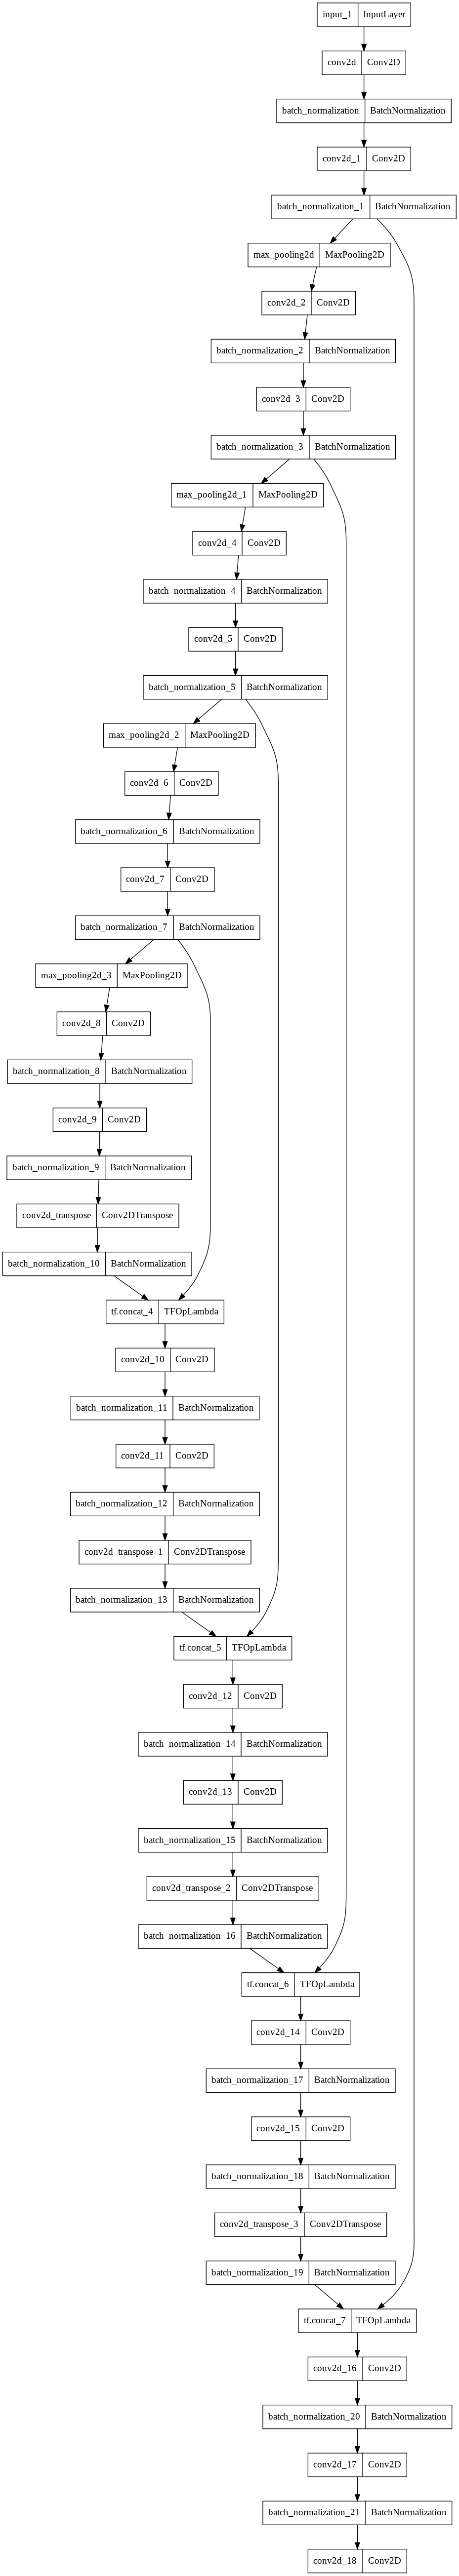

In [ ]:
tf.keras.utils.plot_model(model)

## Compilation du modèle

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
#history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=val_ds, validation_steps=validation_steps, epochs=50)

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 1.2485 - acc: 0.6991 

## Analyse des résultats

Les résultats des valeurs de précision / coefficient de Dice /etc sont présents dans la note technique associés a ce notebook. Je n'ai pas trouver le moyen de récupérer l'historique d'entrainement via le modele déja enregistré et j'ai préféré éviter de refaire un entrainement de 6 heures juste pour afficher les valeurs sur le notebook. on va donc tout simplement charger le modèle déja entrainé

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/P8/modele/Unet/MyUnet')

------------image originelle-----------------------------------------Image segmentée----------------------------image segmentée prédite------------------------


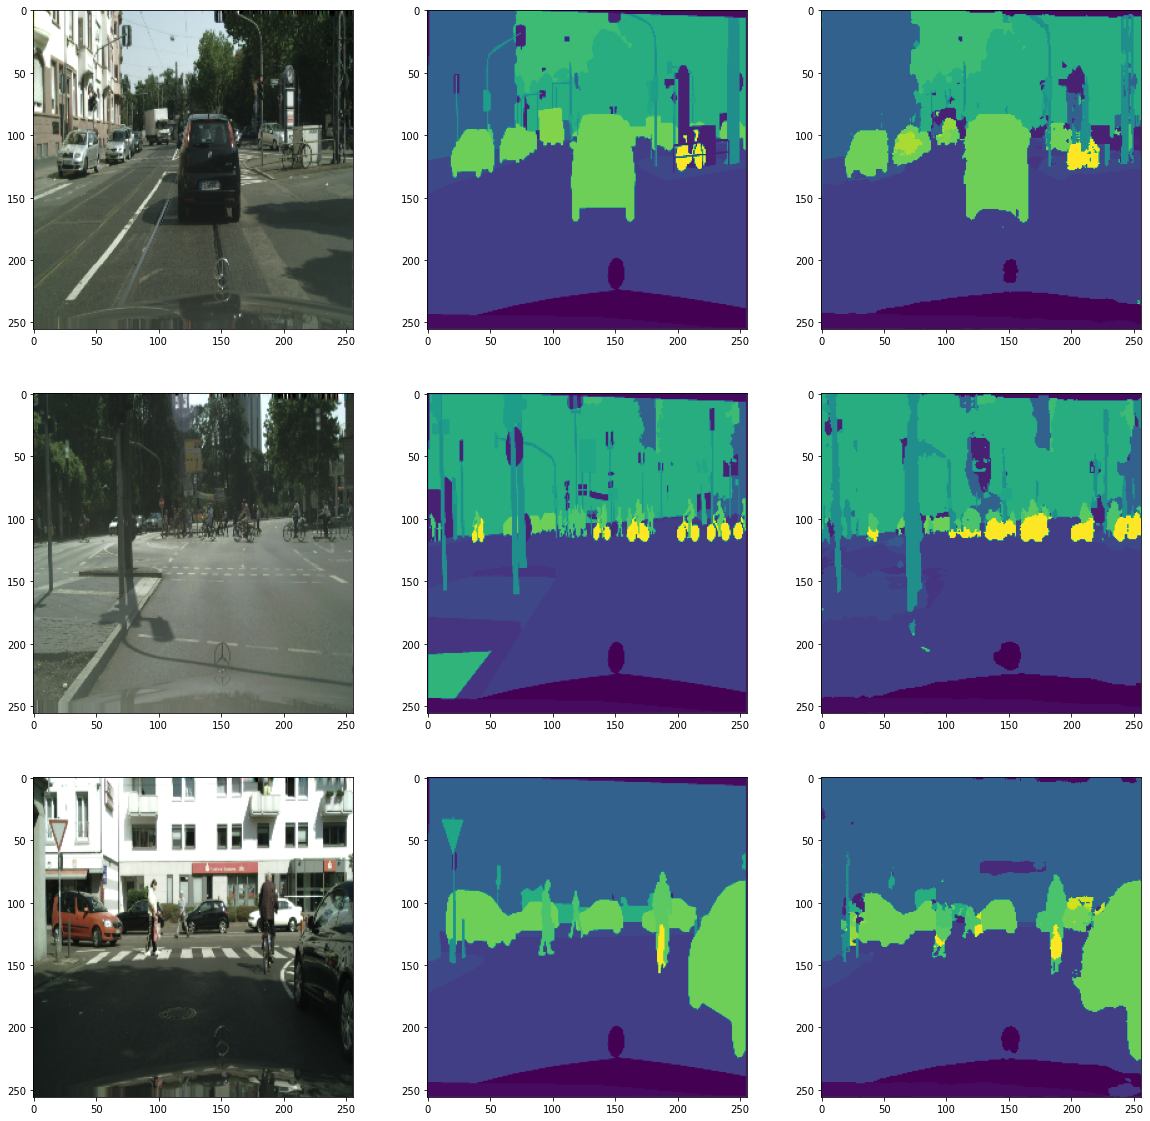

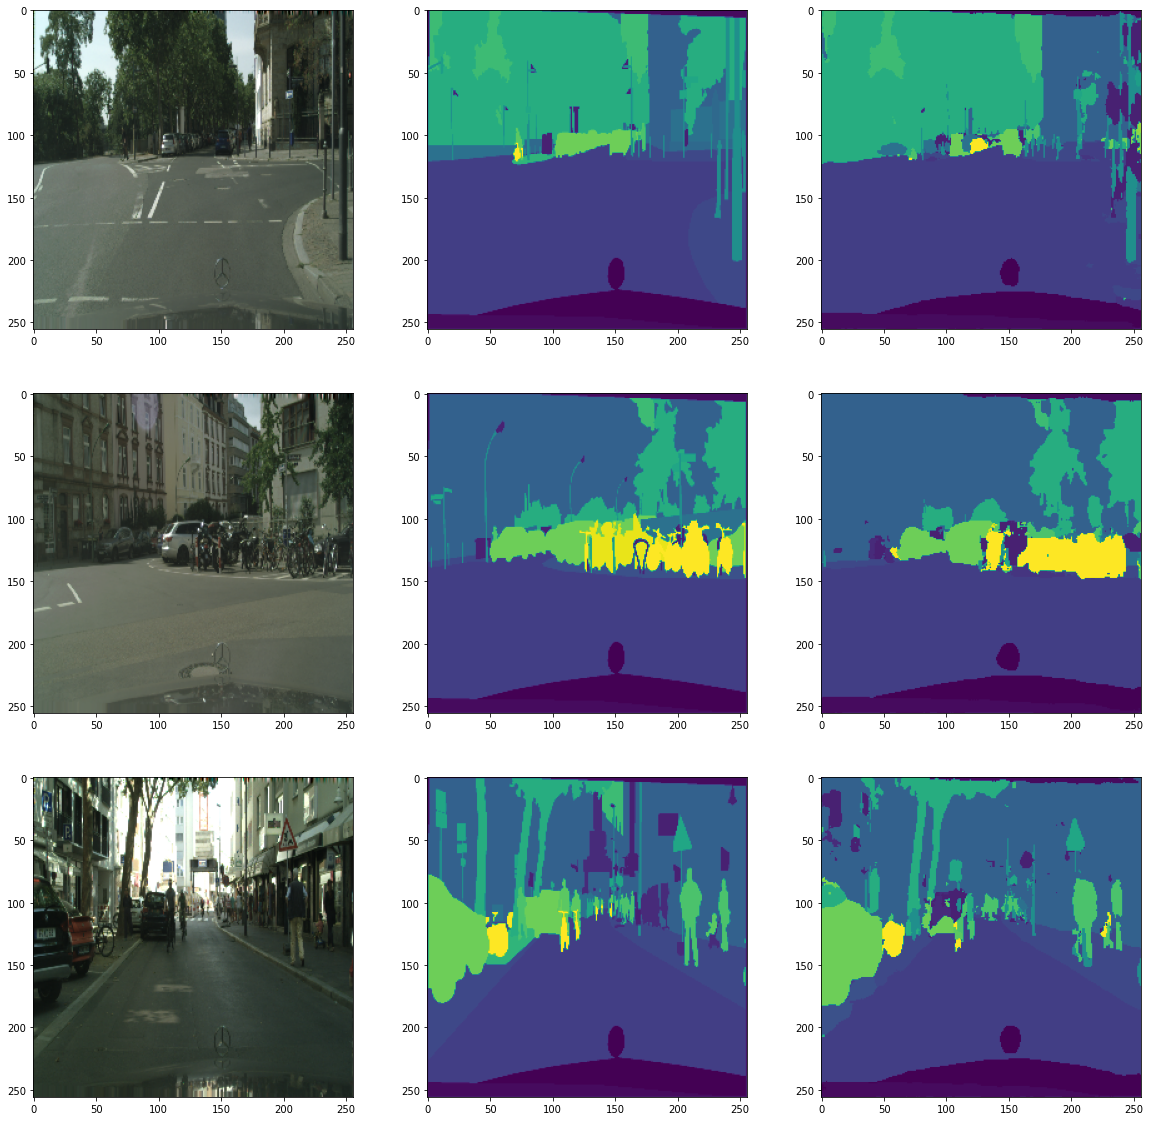

In [ ]:
num = 3

print("------------image originelle-----------------------------------------Image segmentée----------------------------image segmentée prédite------------------------")
for img, label in val_ds.take(2):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1)
    pred_label = pred_label[..., tf.newaxis]
    
    plt.figure(figsize=(20 , 20))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(label[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_label[i]))

